In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# to display matplotlib plots inline (directly below the cell)
%matplotlib inline

Using device: cpu


In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),                   
    transforms.Normalize((0.1307,), (0.3081,))  
])

# get the MNIST dataset for training
train_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    transform=transform,
    download=True
)

full_test_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    transform=transform,
    download=True
)

val_size = 5000
test_size = len(full_test_dataset) - val_size
val_dataset, test_dataset = torch.utils.data.random_split(full_test_dataset, [val_size, test_size])


# create data loaders
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True
)

validation_loader = torch.utils.data.DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    shuffle=False
)

test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False
)

print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")
print(f"Number of batches in training: {len(train_loader)}")
print(f"Number of batches in validation: {len(validation_loader)}")
print(f"Number of batches in testing: {len(test_loader)}")

Training dataset size: 60000
Validation dataset size: 5000
Test dataset size: 5000
Number of batches in training: 1875
Number of batches in validation: 157
Number of batches in testing: 157


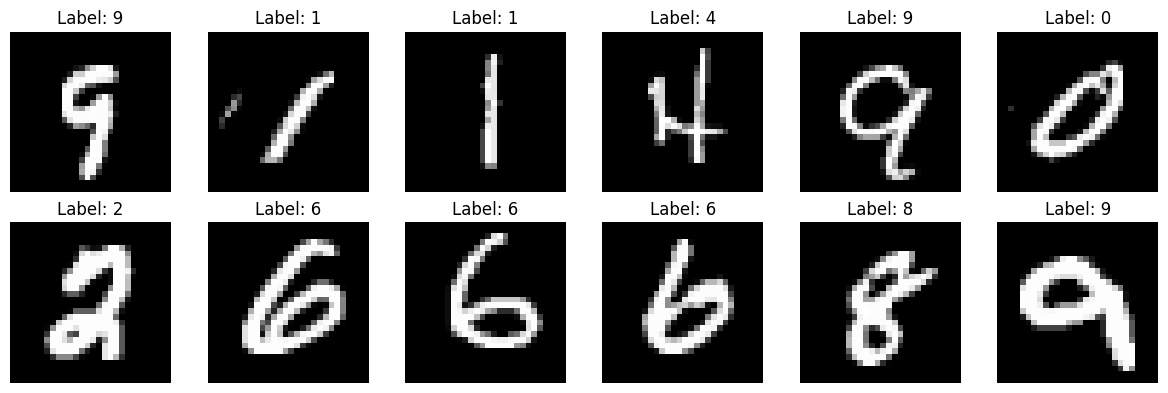

In [3]:
# get a batch of training data
images, labels = next(iter(train_loader))

fig = plt.figure(figsize=(12, 4))
for i in range(12):
    ax = fig.add_subplot(2, 6, i + 1)
    # remove normalization
    img = images[i].squeeze()
    img = img * 0.3081 + 0.1307
    ax.imshow(img, cmap='gray')
    ax.set_title(f'Label: {labels[i].item()}')
    ax.axis('off')
plt.tight_layout()
plt.show()

In [4]:
class PCMNISTNet(nn.Module):
    def __init__(self):
        super(PCMNISTNet, self).__init__()
        self.W1 = nn.Linear(28*28, 256, bias=True)
        self.W2 = nn.Linear(256, 128, bias=True)
        self.W3 = nn.Linear(128, 64, bias=True)
        self.W4 = nn.Linear(64, 10, bias=True)
        # lateral connections for hidden layers 2 and 3
        self.L2 = nn.Linear(128, 128, bias=True)
        self.L3 = nn.Linear(64, 64, bias=True)
        
        for layer in [self.L2, self.L3]:
            nn.init.normal_(layer.weight, mean=0.0, std=0.01)
            mask = ~torch.eye(layer.weight.shape[0], dtype=torch.bool)
            layer.weight.data *= mask # to avoid self connection
            if layer.bias is not None:
                nn.init.zeros_(layer.bias)
                
        self.act = torch.relu

    def predict(self, x, lateral_strength=0.1):
        # forward pass to initialize latent states
        z0 = x.view(x.size(0), -1)
        z1 = self.act(self.W1(z0))
        z2_ff = self.act(self.W2(z1))
        lat2 = self.act(self.L2(z2_ff))
        z2 = z2_ff + lateral_strength * lat2
        z3_ff = self.act(self.W3(z2))
        lat3 = self.act(self.L3(z3_ff))
        z3 = z3_ff + lateral_strength * lat3
        z4 = self.W4(z3) # we want raw outputs here so no activation
        return [z0, z1, z2, z3, z4]

# Instantiate model
model = PCMNISTNet().to(device)
print(model)

PCMNISTNet(
  (W1): Linear(in_features=784, out_features=256, bias=True)
  (W2): Linear(in_features=256, out_features=128, bias=True)
  (W3): Linear(in_features=128, out_features=64, bias=True)
  (W4): Linear(in_features=64, out_features=10, bias=True)
  (L2): Linear(in_features=128, out_features=128, bias=True)
  (L3): Linear(in_features=64, out_features=64, bias=True)
)
